In [1]:
import pandas as pd
import librosa
import os

In [2]:
df = pd.read_csv('./data/results_wav.csv', sep=';')

df.head()

,title,region,keyword,duration,url,path,wav_path
0,KICIR KICIR - Lagu dan Tari Nusantara - Lagu Anak,Jakarta,Kicir-Kicir asal Jakarta,3.54,https://www.youtube.com/watch?v=0wTJULU2REc&pp...,datasets/songs/kicir_kicir_lagu_dan_tari_nusan...,datasets/wav_songs/kicir_kicir_lagu_dan_tari_n...
1,SENAM KREASI KICIR-KICIR || FOR 2024 || DIKLAT...,Jakarta,Kicir-Kicir asal Jakarta,3.32,https://www.youtube.com/watch?v=fni6fgL5C_c&pp...,datasets/songs/senam_kreasi_kicirkicir_for_202...,datasets/wav_songs/senam_kreasi_kicirkicir_for...
2,Kicir Kicir Jakarta,Jakarta,Kicir-Kicir asal Jakarta,3.52,https://www.youtube.com/watch?v=jMynoFKskhc&pp...,datasets/songs/kicir_kicir_jakarta.mp3,datasets/wav_songs/kicir_kicir_jakarta.wav
3,ONDEL ONDEL | Lagu Daerah DKI Jakarta - Betawi...,jakarta,Ondel Ondel asal jakarta,3.39,https://www.youtube.com/watch?v=wardyOl-EHo&pp...,datasets/songs/ondel_ondel_lagu_daerah_dki_jak...,datasets/wav_songs/ondel_ondel_lagu_daerah_dki...
4,ONDEL ONDEL 💞 LAGU DAERAH DKI JAKARTA | ONDEL ...,jakarta,Ondel Ondel asal jakarta,4.44,https://www.youtube.com/watch?v=_X39qcf41ZU&pp...,datasets/songs/ondel_ondel_lagu_daerah_dki_jak...,datasets/wav_songs/ondel_ondel_lagu_daerah_dki...


In [3]:
def get_duration(file_path):
    if file_path is None:
        print('skipping file path is None')
        return None, None
    
    y, sr = librosa.load(file_path)
    duration = librosa.get_duration(y=y, sr=sr)
    print(f'sample rate: {sr}, duration: {duration}')
    return sr, duration

In [4]:
df['sample_rate'], df['duration_sec'] = zip(*df['wav_path'].map(get_duration))


sample rate: 22050, duration: 233.89460317460316
sample rate: 22050, duration: 211.32480725623583
sample rate: 22050, duration: 231.28090702947847
sample rate: 22050, duration: 218.17469387755102
sample rate: 22050, duration: 283.39954648526077
sample rate: 22050, duration: 232.43174603174603
sample rate: 22050, duration: 236.47201814058957
sample rate: 22050, duration: 233.08190476190475


In [27]:
df.describe()

,duration,sample_rate,duration_sec
count,9.000000,9.0,9.000000
mean,3.372222,22050.0,221.167488
std,0.917030,0.0,54.768339
min,1.460000,22050.0,105.627574
25%,3.390000,22050.0,218.174694
50%,3.540000,22050.0,233.081905
75%,3.560000,22050.0,235.798639
max,4.440000,22050.0,283.399546


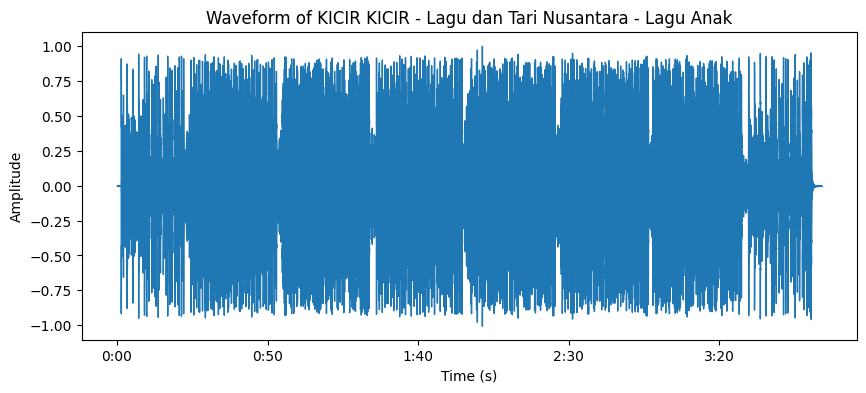

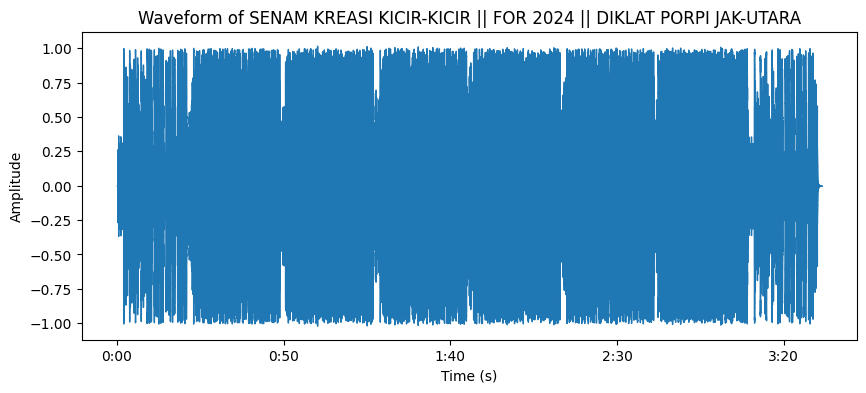

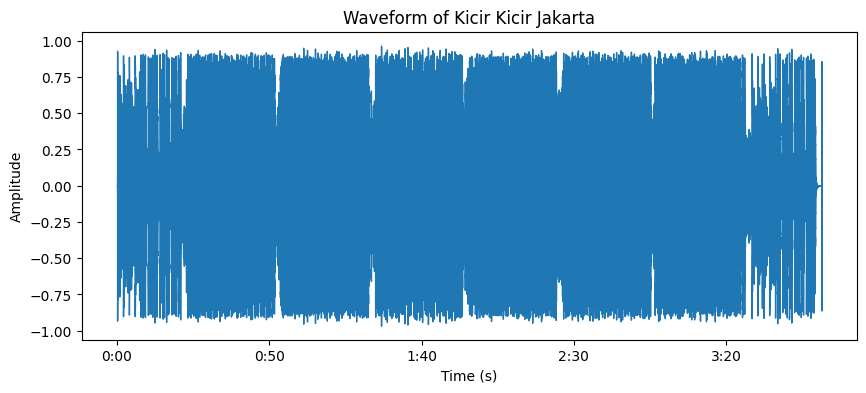

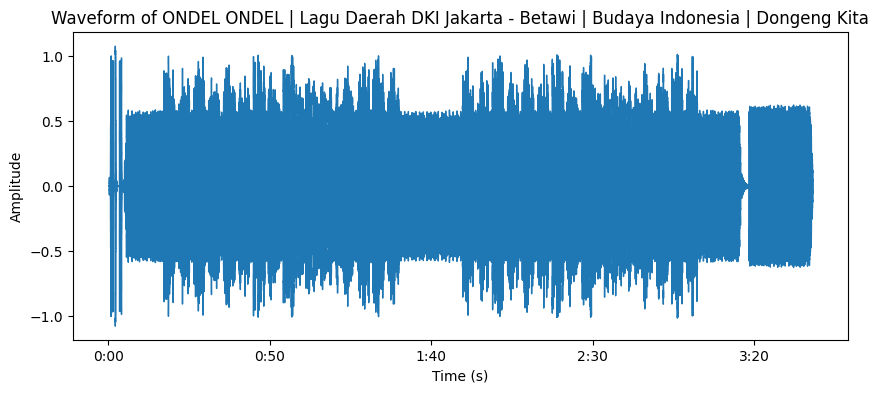

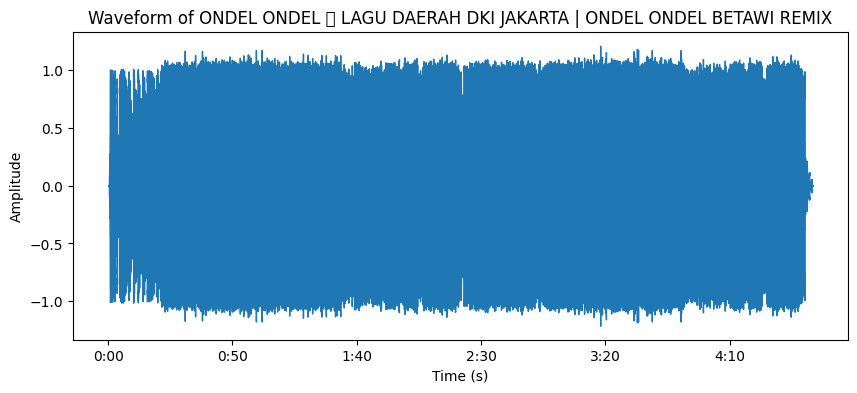

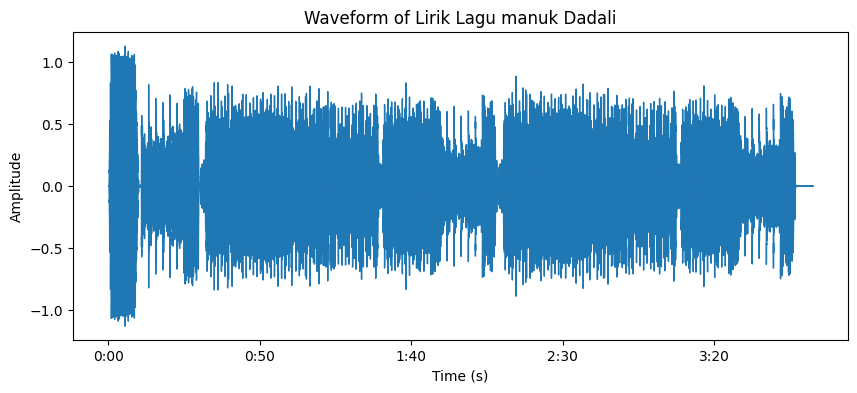

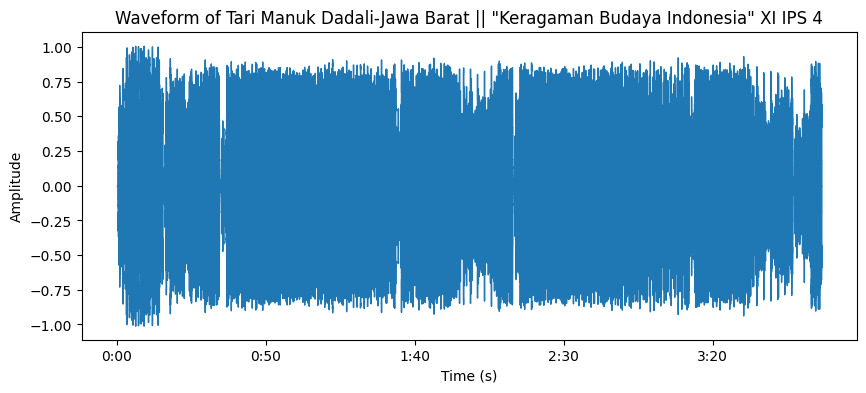

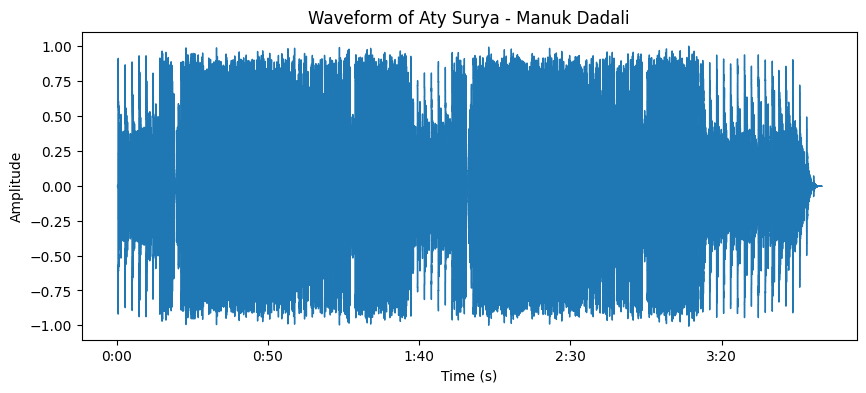

In [6]:

import matplotlib.pyplot as plt

for index, row in df.iterrows():
    y, sr = librosa.load(row['wav_path'])
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform of {row['title']}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

In [8]:
import os
import re
from pydub import AudioSegment

def sanitize_filename(filename):
    """
    Removes or replaces invalid characters from a filename or folder name.
    """
    return re.sub(r'[<>:"/\\|?*]', '', filename)

def split_audio(wav_path, output_dir, segment_duration=30):
    audio = AudioSegment.from_wav(wav_path)
    
    total_duration = len(audio) / 1000 
    
    num_segments = int(total_duration // segment_duration)
    
    os.makedirs(output_dir, exist_ok=True)
    
    for i in range(num_segments):
        start_time = i * segment_duration * 1000 
        end_time = (i + 1) * segment_duration * 1000 
        segment = audio[start_time:end_time]
        
        segment_file = os.path.join(output_dir, f"{os.path.basename(wav_path).replace('.wav', '')}segment{i + 1}.wav")
        segment.export(segment_file, format="wav")
        print(f"Saved segment {i + 1} at: {segment_file}")

input_folder = "datasets/wav_songs"
output_folder = "datasets/cut_wav_songs"

wav_files = [f for f in os.listdir(input_folder) if f.endswith('.wav')]

for wav_file in wav_files:
    wav_path = os.path.join(input_folder, wav_file)
    
    sanitized_title = sanitize_filename(os.path.splitext(wav_file)[0])
    output_dir = os.path.join(output_folder, sanitized_title)
    
    split_audio(wav_path, output_dir, segment_duration=30)

Saved segment 1 at: datasets/cut_wav_songs\aty_surya_manuk_dadali\aty_surya_manuk_dadalisegment1.wav
Saved segment 2 at: datasets/cut_wav_songs\aty_surya_manuk_dadali\aty_surya_manuk_dadalisegment2.wav
Saved segment 3 at: datasets/cut_wav_songs\aty_surya_manuk_dadali\aty_surya_manuk_dadalisegment3.wav
Saved segment 4 at: datasets/cut_wav_songs\aty_surya_manuk_dadali\aty_surya_manuk_dadalisegment4.wav
Saved segment 5 at: datasets/cut_wav_songs\aty_surya_manuk_dadali\aty_surya_manuk_dadalisegment5.wav
Saved segment 6 at: datasets/cut_wav_songs\aty_surya_manuk_dadali\aty_surya_manuk_dadalisegment6.wav
Saved segment 7 at: datasets/cut_wav_songs\aty_surya_manuk_dadali\aty_surya_manuk_dadalisegment7.wav
Saved segment 1 at: datasets/cut_wav_songs\kicir_kicir_jakarta\kicir_kicir_jakartasegment1.wav
Saved segment 2 at: datasets/cut_wav_songs\kicir_kicir_jakarta\kicir_kicir_jakartasegment2.wav
Saved segment 3 at: datasets/cut_wav_songs\kicir_kicir_jakarta\kicir_kicir_jakartasegment3.wav
Saved se